In [214]:
import os
import numpy as np
import pandas as pd
from osgeo import gdal, osr
import h5py
import matplotlib.pylab as plt
import xarray as xr
import rioxarray


def qa_num_to_binary(qa_num):
    # Return True if good vegetation data else False
    # Refer to the DSCOVR manual for the QA codes
    if np.isnan(qa_num):
        return False
    else:
        binary_string = bin(int(qa_num) & 0xFFFF)[2:].zfill(16)
        if np.all(np.array(list(binary_string)[-13:]) == "0"):
            return True
        return False

        # return binary_string


vectorized_qa_num_to_binary = np.vectorize(qa_num_to_binary)


def filter_qa(h5f, tile, field):
    var = np.array(h5f[tile][field])
    var = var.astype(float)
    var[(var >= -9999) & (var <= -9997)] = np.nan
    qa = np.array(h5f[tile]["06_QA_VESDR"])
    qa = np.where(np.isfinite(var), qa, np.nan)
    good_flag = vectorized_qa_num_to_binary(qa)
    if field == "12_ERTI":
        Scale_factor = 0.01
    elif (
        (field == "13_W443")
        | (field == "14_W551")
        | (field == "15_W680")
        | (field == "16_W780")
        | (field == "07_SZA")
        | (field == "08_VZA")
        | (field == "09_SAA")
        | (field == "10_VAA")
    ):
        Scale_factor = 1
    else:
        # Scale factor for LAI,SLAI,FPAR,NDVI,DASF
        Scale_factor = 0.001

    var_good = np.where(good_flag == True, var, np.nan) * Scale_factor
    print(Scale_factor)
    return var_good


def make_vrt(outpath, xyPath, tile, var_good, field, date):
    # xypath only has the geometric info so we can use it for
    xyf = h5py.File(xyPath, "r")
    # Get geolocations from land cover map and create a vrt map
    xyf_x = np.array(xyf[tile]["Geolocation"]["Longitude"]).reshape(-1, 1)
    xyf_y = np.array(xyf[tile]["Geolocation"]["Latitude"]).reshape(-1, 1)
    # h5f_t = np.array(h5f[tile][field]).reshape(-1,1)
    h5f_t = var_good.reshape(-1, 1)

    out = np.hstack((xyf_x, xyf_y, h5f_t))
    out = out.astype(float)
    df = pd.DataFrame(out, columns=["Lon", "Lat", "data"])
    df = df[df["Lon"] > -999.0]
    df = df[df["Lat"] > -999.0]
    df.data[df.data <= -9998] = -9999.0

    df.to_csv(
        os.path.join(outpath, "{0}_{1}_{2}.csv".format(tile, field, date)),
        sep=",",
        index=False,
    )
    msg = """<OGRVRTDataSource>
        <OGRVRTLayer name="{1}_{2}_{3}">
            <SrcDataSource>{0}{1}_{2}_{3}.csv</SrcDataSource>
            <GeometryType>wkbPoint</GeometryType>
            <GeometryField encoding="PointFromColumns" x="Lon" y="Lat" z="data"/>
        </OGRVRTLayer>
    </OGRVRTDataSource>""".format(
        outpath, tile, field, date
    )

    msgpath = os.path.join(outpath, "{0}_{1}_{2}.vrt".format(tile, field, date))
    file = open(msgpath, "w")
    file.write(msg)
    file.close()


def reproject(inputfile1, inputfile2, outputfile, xmin, xmax, ymin, ymax):
    scmd = (
        "gdal_grid -a linear:radius=0:nodata=-9999.0 -txe %f %f -tye %f %f -tr 0.1 0.1 -a_srs EPSG:4326 -of GTiff -ot Float64 -l %s %s %s"
        % (xmin, xmax, ymin, ymax, inputfile1, inputfile2, outputfile)
    )
    os.system(scmd)

### Filter the data


In [210]:
# Open the hdf file
root = "/home/hamid/dscovr/"
file = "data/DSCOVR_EPIC_L2_VESDR_02_20160823152458_03.h5"
h5fpath = os.path.join(root, file)

h5f = h5py.File(h5fpath, "r")
date = file.split("_")[5]
# Get the exisitng tile list in the file
tile_list = [key for key in h5f.keys()]

# Get the variables of each tile existing in the file
# and filter for good values based on QAs
field_list = [
    "01_LAI",
    "02_SLAI",
    "03_FPAR",
    "05_NDVI",
    "07_SZA",
    "08_VZA",
    "09_SAA",
    "10_VAA",
    "11_DASF",
    "12_ERTI",
    "13_W443",
    "14_W551",
    "15_W680",
    "16_W780",
]
tile = tile_list[4]
field = field_list[0]
print([tile, field])
print(tile_list)

['tile31', '01_LAI']
['tile00', 'tile01', 'tile20', 'tile30', 'tile31']


0.001


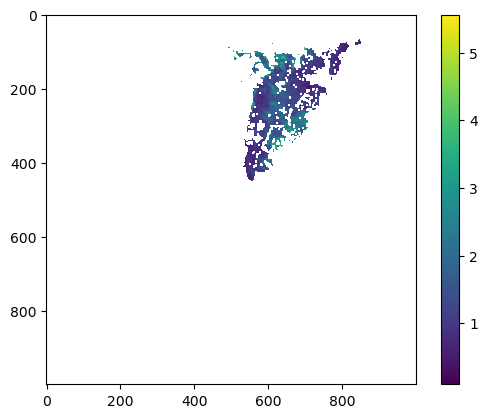

In [211]:
var_good = filter_qa(h5f, tile, field)

### Reproject to WGS


In [215]:
outpath = r"/home/hamid/dscovr/outputs/"
xyPath = root + "data/MCDLCHKM.V2010_01.REGIONALbio.10018m.BlocksOP.h5"
make_vrt(outpath, xyPath, tile, var_good, field, date)

In [222]:
if tile == "tile00":
    xmin, xmax = -25, 65
    ymin, ymax = 0, 90
if tile == "tile01":
    xmin, xmax = -25, 65
    ymin, ymax = -90, 0

if tile == "tile10":
    xmin, xmax = 65, 155
    ymin, ymax = 0, 90

if tile == "tile11":
    xmin, xmax = 65, 155
    ymin, ymax = -90, 0

if tile == "tile30":
    xmin, xmax = -115, -25
    ymin, ymax = 0, 90

if tile == "tile31":
    xmin, xmax = -115, -25
    ymin, ymax = -90, 0

inputfile1 = tile + "_" + field + "_" + date
inputfile2 = outpath + tile + "_" + field + "_" + date + ".vrt"
outputfile = outpath + field + "_" + date + "_" + tile + ".tif"

In [223]:
reproject(inputfile1, inputfile2, outputfile, xmin, xmax, ymin, ymax)

Grid data type is "Float64"
Grid size = (900 900).
Corner coordinates = (-115.000000 0.000000)-(-25.000000 -90.000000).
Grid cell size = (0.100000 -0.100000).
Source point count = 918378.
Algorithm name: "linear".
Options are "radius=0.000000:nodata=-9999.000000"

0...10...20...30...40...50...60...70...80...90...100 - done.


In [100]:
if tile == "tile20":
    # Do the US side
    xmin, xmax = -180, -115
    ymin, ymax = 0, 90
    inputfile1 = tile + "_" + field + "_" + date
    inputfile2 = outpath + tile + "_" + field + "_" + date + ".vrt"
    outputfile = outpath + field + "_" + date + "_" + tile + "_US.tif"
    scmd = (
        "gdal_grid -a linear:radius=0:nodata=-9999.0 -txe %f %f -tye %f %f -tr 0.1 0.1 -a_srs EPSG:4326 -of GTiff -ot Float64 -l %s %s %s"
        % (xmin, xmax, ymin, ymax, inputfile1, inputfile2, outputfile)
    )
    os.system(scmd)

    # Do the Asia side
    xmin, xmax = 155, 180
    inputfile1 = tile + "_" + field + "_" + date
    inputfile2 = outpath + tile + "_" + field + "_" + date + ".vrt"
    outputfile = outpath + field + "_" + date + "_" + tile + "_Asia.tif"
    scmd = (
        "gdal_grid -a linear:radius=0:nodata=-9999.0 -txe %f %f -tye %f %f -tr 0.1 0.1 -a_srs EPSG:4326 -of GTiff -ot Float64 -l %s %s %s"
        % (xmin, xmax, ymin, ymax, inputfile1, inputfile2, outputfile)
    )
    os.system(scmd)

if tile == "tile21":
    # Do the US side
    xmin, xmax = -180, -115
    ymin, ymax = -90, 0
    inputfile1 = tile + "_" + field + "_" + date
    inputfile2 = outpath + tile + "_" + field + "_" + date + ".vrt"
    outputfile = outpath + field + "_" + date + "_" + tile + "_US.tif"
    scmd = (
        "gdal_grid -a linear:radius=0:nodata=-9999.0 -txe %f %f -tye %f %f -tr 0.1 0.1 -a_srs EPSG:4326 -of GTiff -ot Float64 -l %s %s %s"
        % (xmin, xmax, ymin, ymax, inputfile1, inputfile2, outputfile)
    )
    os.system(scmd)

    # Do the Asia side
    xmin, xmax = 155, 180
    inputfile1 = tile + "_" + field + "_" + date
    inputfile2 = outpath + tile + "_" + field + "_" + date + ".vrt"
    outputfile = outpath + field + "_" + date + "_" + tile + "_Asia.tif"
    scmd = (
        "gdal_grid -a linear:radius=0:nodata=-9999.0 -txe %f %f -tye %f %f -tr 0.1 0.1 -a_srs EPSG:4326 -of GTiff -ot Float64 -l %s %s %s"
        % (xmin, xmax, ymin, ymax, inputfile1, inputfile2, outputfile)
    )
    os.system(scmd)

Grid data type is "Float64"
Grid size = (650 900).
Corner coordinates = (-180.000000 90.000000)-(-115.000000 0.000000).
Grid cell size = (0.100000 -0.100000).
Source point count = 919378.
Algorithm name: "linear".
Options are "radius=0.000000:nodata=-9999.000000"

0...10...20...30...40...50...60...70...80...90...100 - done.
Grid data type is "Float64"
Grid size = (250 900).
Corner coordinates = (155.000000 90.000000)-(180.000000 0.000000).
Grid cell size = (0.100000 -0.100000).
Source point count = 919378.
Algorithm name: "linear".
Options are "radius=0.000000:nodata=-9999.000000"

0...10...20...30...40...50...60...70...80...90...100 - done.
